In [1]:
import numpy as np
import pandas as pd 
import re, string 
import spacy
import sys
import nltk
from nltk.tokenize import word_tokenize
from collections import defaultdict
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
SW = set(stopwords.words('english'))
from gensim.models import Word2Vec
%matplotlib inline

df = pd.read_csv('BBC news dataset.csv')

In [2]:
#Tokenize words in each article
tokenization = df['description'].apply(word_tokenize)
print(tokenization)

0       [chelsea, sack, mutu, chelsea, have, sacked, a...
1       [record, fails, to, lift, lacklustre, meet, ye...
2       [edu, describes, tunnel, fracas, arsenals, edu...
3       [ogara, revels, in, ireland, victory, ireland,...
4       [unclear, future, for, striker, baros, liverpo...
                              ...                        
2405    [gm, in, crunch, talks, on, fiat, future, fiat...
2406    [uk, firm, faces, venezuelan, land, row, venez...
2407    [winndixie, files, for, bankruptcy, us, superm...
2408    [yangtze, electrics, profits, double, yangtze,...
2409    [algeria, hit, by, further, gas, riots, algeri...
Name: description, Length: 2410, dtype: object


In [3]:
#Delete the stopwords, punctuation
def processing(x):
    x = x.lower()
    x = re.sub(r'\[.*?\]', '', x)
    x = re.sub(r'[%s]' % re.escape(string.punctuation), '', x)
    x = re.sub(r'\w*\d\w*', '', x)

    x = word_tokenize(x)
    if len(x) > 2:
        return [word for word in x if word not in SW]
    
data = df['description'].apply(lambda x: processing(x))
print(data)

0       [chelsea, sack, mutu, chelsea, sacked, adrian,...
1       [record, fails, lift, lacklustre, meet, yelena...
2       [edu, describes, tunnel, fracas, arsenals, edu...
3       [ogara, revels, ireland, victory, ireland, fly...
4       [unclear, future, striker, baros, liverpool, f...
                              ...                        
2405    [gm, crunch, talks, fiat, future, fiat, meet, ...
2406    [uk, firm, faces, venezuelan, land, row, venez...
2407    [winndixie, files, bankruptcy, us, supermarket...
2408    [yangtze, electrics, profits, double, yangtze,...
2409    [algeria, hit, gas, riots, algeria, suffered, ...
Name: description, Length: 2410, dtype: object


In [4]:
vocabulary = []
for sentence in data:
    for word in sentence:
        if word not in vocabulary:
            vocabulary.append(word)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)
word2idx

{'chelsea': 0,
 'sack': 1,
 'mutu': 2,
 'sacked': 3,
 'adrian': 4,
 'failed': 5,
 'drugs': 6,
 'test': 7,
 'yearold': 8,
 'tested': 9,
 'positive': 10,
 'banned': 11,
 'substance': 12,
 'later': 13,
 'denied': 14,
 'cocaine': 15,
 'october': 16,
 'decided': 17,
 'write': 18,
 'possible': 19,
 'transfer': 20,
 'fee': 21,
 'signing': 22,
 'parma': 23,
 'last': 24,
 'season': 25,
 'may': 26,
 'face': 27,
 'twoyear': 28,
 'suspension': 29,
 'statement': 30,
 'explaining': 31,
 'decision': 32,
 'readwe': 33,
 'want': 34,
 'make': 35,
 'clear': 36,
 'zero': 37,
 'tolerance': 38,
 'policy': 39,
 'towards': 40,
 'scored': 41,
 'six': 42,
 'goals': 43,
 'first': 44,
 'five': 45,
 'games': 46,
 'arriving': 47,
 'stamford': 48,
 'bridge': 49,
 'form': 50,
 'went': 51,
 'decline': 52,
 'frozen': 53,
 'coach': 54,
 'jose': 55,
 'mourinho': 56,
 'chelseas': 57,
 'added': 58,
 'applies': 59,
 'performanceenhancing': 60,
 'socalled': 61,
 'recreational': 62,
 'place': 63,
 'club': 64,
 'sport': 65,
 '

In [5]:
#Lemmatize articles and clean text
nlp = spacy.load('en') 
prepared_text = pd.DataFrame(data)

def lemmatizer(x):        
    sent = []
    doc = nlp(" ".join(x))
    for word in doc:
        sent.append(word.lemma_)
    return sent

prepared_text["lemmatized_text"] =  prepared_text.apply(lambda x: lemmatizer(x['description']), axis=1)
prepared_text

,description,lemmatized_text
0,"[chelsea, sack, mutu, chelsea, sacked, adrian,...","[chelsea, sack, mutu, chelsea, sack, adrian, m..."
1,"[record, fails, lift, lacklustre, meet, yelena...","[record, fail, lift, lacklustre, meet, yelena,..."
2,"[edu, describes, tunnel, fracas, arsenals, edu...","[edu, describe, tunnel, fracas, arsenal, edu, ..."
3,"[ogara, revels, ireland, victory, ireland, fly...","[ogara, revel, ireland, victory, ireland, flyh..."
4,"[unclear, future, striker, baros, liverpool, f...","[unclear, future, striker, baros, liverpool, f..."
...,...,...
2405,"[gm, crunch, talks, fiat, future, fiat, meet, ...","[gm, crunch, talk, fiat, future, fiat, meet, c..."
2406,"[uk, firm, faces, venezuelan, land, row, venez...","[uk, firm, face, venezuelan, land, row, venezu..."
2407,"[winndixie, files, bankruptcy, us, supermarket...","[winndixie, file, bankruptcy, us, supermarket,..."
2408,"[yangtze, electrics, profits, double, yangtze,...","[yangtze, electrics, profit, double, yangtze, ..."


In [6]:
#Use word2vec in order to receive vectors
import sys

sentences = [row for row in prepared_text["lemmatized_text"]]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
        
sorted(word_freq, key=word_freq.get, reverse=True)[:10]
        
w2v_model = Word2Vec(min_count=10,
                     window=5,
                     size=200,
                     workers=4)
                     
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)
w2v_model.init_sims(replace=True)

In [7]:
w2v_model.wv.most_similar(positive=['america'])

[('cml', 0.9883313179016113),
 ('north', 0.9867379665374756),
 ('monthly', 0.9837157130241394),
 ('post', 0.9829404950141907),
 ('months', 0.9820782542228699),
 ('hong', 0.9815584421157837),
 ('raid', 0.9801430106163025),
 ('commerce', 0.9797340631484985),
 ('athletics', 0.9787150025367737),
 ('industrialise', 0.9786970615386963)]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


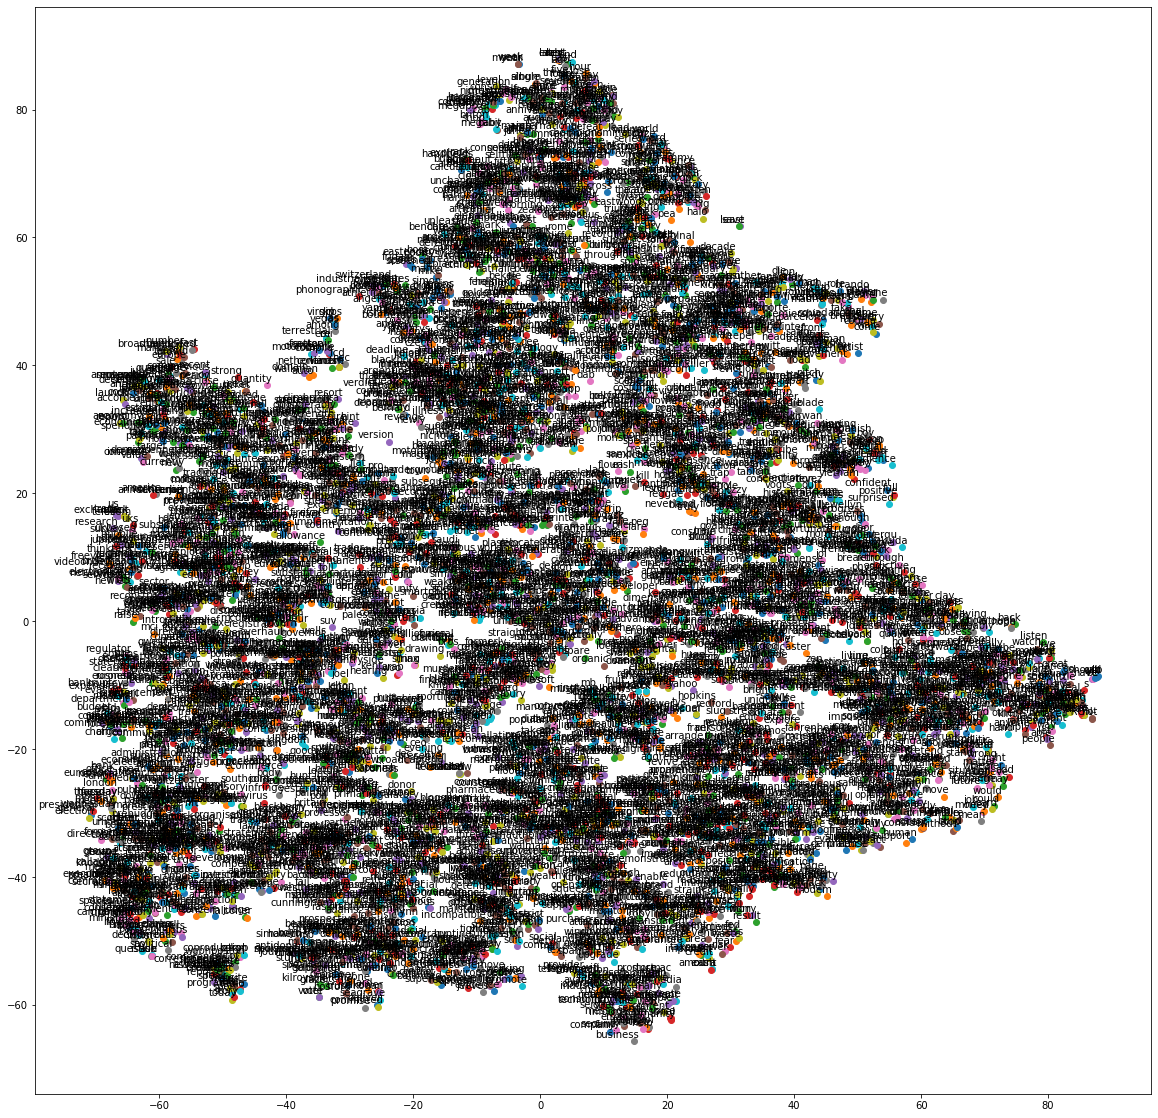

In [8]:
#Visualization of words in space
import sys
from matplotlib import pyplot as plt
%matplotlib inline

def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne_plot(w2v_model)

In [9]:
vector = w2v_model.wv['america']  # numpy vector of a word
print(len(vector))
print(vector)

200
[-0.02573381  0.06799047 -0.05164653  0.06660233 -0.00306274  0.06654337
 -0.11786927  0.07556266 -0.00431459  0.0681632   0.2029563   0.04343097
 -0.01790511  0.06108399 -0.05325727  0.10280616 -0.03133406 -0.00928459
  0.15454635 -0.10433275  0.16615582 -0.03640997 -0.05517126 -0.06556956
  0.03916203 -0.01788503  0.05080085 -0.01183455  0.03578476  0.08659077
 -0.07900542  0.03404001  0.07569461 -0.00483121 -0.03883059 -0.03372104
 -0.11857928  0.01556685 -0.08929364 -0.08171485  0.03780058 -0.06214521
  0.16631763 -0.15855438 -0.03287427  0.03347824  0.06200187  0.08963535
  0.07696873  0.03748533  0.04719334 -0.01427325  0.13916877 -0.01404667
 -0.03898353  0.02368057 -0.04502125  0.13045344 -0.01964989  0.05170444
  0.09947172  0.02462213  0.10008297  0.01931668  0.03920499 -0.06064981
 -0.04531043  0.00329569  0.02701644  0.02215802  0.0393194   0.0241553
 -0.11300302  0.0285394   0.06168384 -0.04487768  0.11552085 -0.04925812
 -0.1716549  -0.06585339 -0.11599628 -0.04083088